**Imports**

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
colors = ['midnightblue','dodgerblue', 'violet','darkviolet','crimson','tomato','orange','indianred','palegreen','seagreen']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

**Reading data**

In [60]:
def parse_data(file_path): # Neat for the .txt file
    data_sets = {}
    current_set = None
    errors = 0
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith("Data set"):
                current_set = line
                data_sets[current_set] = []
            elif line:
                try:
                    x, y = map(float, line.split('\t'))
                    data_sets[current_set].append([x, y])
                except Exception as e: # An error usually appears due to the initial string line
                    errors += 1

    return data_sets , errors # Get the data sets as a dictionary

data_sets , errors = parse_data('FranksNumbers.txt') # Get the data sets

In [61]:
def parse_data_pd(file_path):

    data = []
    current_set = None
    errors = 0

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith("Data set"):
                current_set = line.replace("Data set", "").strip()
            elif line:
                try:
                    x, y = map(float, line.split('\t'))
                    data.append([current_set, x, y])
                except ValueError:  # This is more specific than catching all Exceptions
                    errors += 1

    # Convert list to DataFrame
    df = pd.DataFrame(data, columns=['Data Set', 'X', 'Y'])

    # Return the DataFrame and the number of errors encountered
    return df, errors

file_path = 'FranksNumbers.txt'
df, errors = parse_data_pd(file_path)


**Plot data**

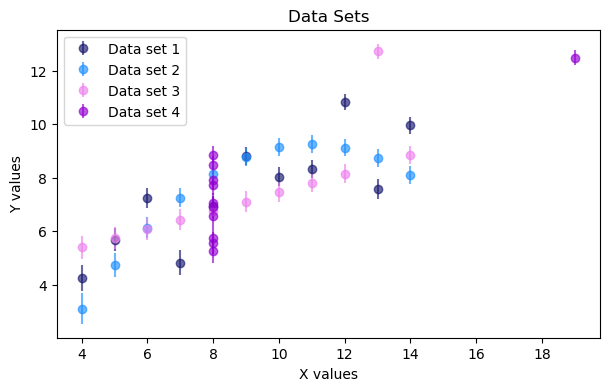

In [75]:
grouped = df.groupby('Data Set')


plt.figure(figsize=(7, 4))

for name , group in list(grouped)[:-1]:
    plt.errorbar(group['X'], group['Y'],yerr=1/(np.sqrt(group['Y'])), marker='o', linestyle='',alpha=0.65, label=f'Data set {name}')
    
plt.title(f'Data Sets')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.show()

**Compute means and variances**

With .txt parser

In [63]:
means = []
variances = []

for data in data_sets.values():
    
    x_values = [item[0] for item in data]
    y_values = [item[1] for item in data]
    
    means.append( np.average(y_values,weights=x_values)) 
    variances.append( np.var(y_values,ddof=0))
    
print(means)
print(variances)

[8.056565656565656, 8.056464646464647, 8.055252525252524, 8.056363636363637, 8.056161616161615]
[3.7520628099173554, 3.752390082644628, 3.747836363636364, 3.7484082644628103, 3.7501745351239673]


With dataframe parser

In [64]:
means = []
variances = []

for name, group in grouped:
    # Calculate the weighted mean for 'Y' using 'X' as weights
    weighted_mean = np.average(group['Y'], weights=group['X'])
    means.append(weighted_mean)
    
    # Calculate the variance for 'Y'
    variance = np.var(group['Y'], ddof=0)
    variances.append(variance)

# Print the results
print("Means:", means)
print("Variances:", variances)

Means: [8.056565656565656, 8.056464646464647, 8.055252525252524, 8.056363636363637, 8.056161616161615]
Variances: [3.7520628099173554, 3.7523900826446277, 3.747836363636364, 3.74840826446281, 3.7501745351239673]


**Chi2**

In [65]:
def test_function(x):
    return x*0.48 + 3.02

With .txt parser

In [66]:
chi_values = []

for data in data_sets.values():
    
    x_values = [item[0] for item in data]
    y_values = [item[1] for item in data]
    
    obs_y_values = [test_function(x) for x in x_values] # Get the y-values from function
    
    sy_values_1 = np.sqrt(obs_y_values) # Get uncertainties from Poisson error
    sy_values_2 = [1.22 for x in range(len(y_values))] # Get uncertainties from 1.22

    chi2_1 = 0 # Chi2 using Poisson error
    chi2_2 = 0 # Chi2 using 1.22
        
    for y_2 , y_1 , sy_1 in zip(y_values,obs_y_values,sy_values_1):
        chi2_1 += ((y_2 - y_1)**2) / ( sy_1**2 ) # Compute Chi (Poisson)
        
    for y_2 , y_1 , sy_1 in zip(y_values,obs_y_values,sy_values_2):
        chi2_2 += ((y_2 - y_1)**2) / ( sy_1**2 ) # Compute Chi (1.22)
    
    red_chi2_1 = chi2_1 / (len(x_values)-2)
    red_chi2_2 = chi2_2 / (len(x_values)-2)
    
    chi_values.append([chi2_1,chi2_2,red_chi2_1,red_chi2_2])

With .pd parser

In [67]:
chi_values = []

for name, group in grouped:
    x_values = group['X'].values
    y_values = group['Y'].values
    
    # Compute expected y-values using the test function for each x
    obs_y_values = np.array([test_function(x) for x in x_values])
    
    # Compute uncertainties from Poisson error and a constant value
    sy_values_1 = np.sqrt(obs_y_values)  # Uncertainties from Poisson error
    sy_values_2 = np.array([1.22] * len(y_values))  # Uncertainties from a constant value
    
    # Calculate chi-squared values
    chi2_1 = np.sum(((y_values - obs_y_values) ** 2) / sy_values_1 ** 2)
    chi2_2 = np.sum(((y_values - obs_y_values) ** 2) / sy_values_2 ** 2)
    
    # Calculate reduced chi-squared values
    red_chi2_1 = chi2_1 / (len(x_values) - 2)
    red_chi2_2 = chi2_2 / (len(x_values) - 2)
    
    chi_values.append([chi2_1, chi2_2, red_chi2_1, red_chi2_2])

# Convert chi_values list to DataFrame for better readability and manipulation
chi_df = pd.DataFrame(chi_values, columns=['Chi2 Poisson', 'Chi2 Constant', 'Reduced Chi2 Poisson', 'Reduced Chi2 Constant'])
chi_df.index = grouped.groups.keys()  # Set the index to the data set names for reference

print(chi_df)

   Chi2 Poisson  Chi2 Constant  Reduced Chi2 Poisson  Reduced Chi2 Constant
1      1.886825       9.467818              0.209647               1.051980
2      2.071576       9.476686              0.230175               1.052965
3      1.554539       9.460226              0.172727               1.051136
4      2.042935       9.453709              0.226993               1.050412
5      7.555875      37.858439              0.179902               0.901391


**Summed up**

In [68]:
count = 1

for mean,variance,chi2 in zip(means,variances,chi_values):
    
    print(f'For Data Set {count};')
    #print(f'mean is {mean}')
    #print(f'Variance is {variance}')
    print(f'Chi2 (sigma = sqrt(y)) is {chi2[0]}')
    print(f'Chi2 (sigma = 1.22) is {chi2[1]}')
    print(f'Redcued chi2 (sigma = sqrt(y)) is {chi2[2]}')
    print(f'Reduced chi2 (sigma = 1.22) is {chi2[3]}')
    
    count += 1

For Data Set 1;
Chi2 (sigma = sqrt(y)) is 1.886825303845903
Chi2 (sigma = 1.22) is 9.46781779091642
Redcued chi2 (sigma = sqrt(y)) is 0.20964725598287812
Reduced chi2 (sigma = 1.22) is 1.051979754546269
For Data Set 2;
Chi2 (sigma = sqrt(y)) is 2.0715758463593357
Chi2 (sigma = 1.22) is 9.476686374630479
Redcued chi2 (sigma = sqrt(y)) is 0.2301750940399262
Reduced chi2 (sigma = 1.22) is 1.0529651527367199
For Data Set 3;
Chi2 (sigma = sqrt(y)) is 1.5545390861808746
Chi2 (sigma = 1.22) is 9.460225745767271
Redcued chi2 (sigma = sqrt(y)) is 0.1727265651312083
Reduced chi2 (sigma = 1.22) is 1.0511361939741413
For Data Set 4;
Chi2 (sigma = sqrt(y)) is 2.0429349282664355
Chi2 (sigma = 1.22) is 9.453708680462244
Redcued chi2 (sigma = sqrt(y)) is 0.22699276980738173
Reduced chi2 (sigma = 1.22) is 1.050412075606916
For Data Set 5;
Chi2 (sigma = sqrt(y)) is 7.555875164652551
Chi2 (sigma = 1.22) is 37.85843859177643
Redcued chi2 (sigma = sqrt(y)) is 0.17990178963458453
Reduced chi2 (sigma = 1.22)